In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

data = pd.read_csv('cloud-data/bus_data_modified.csv')
data.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
0,4855,4131,Transit Bus,212.735226,LX Route,02:23 PM,-74.433571,40.519749,0,67,101,402213,111417,2024-10-31 18:24:00,0.000000,Quads
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 18:24:00,0.402985,Livingston Student Center
2,4873,4191,Transit Bus,240.802514,B Route,02:23 PM,-74.457712,40.523463,8,67,101,402329,113278,2024-10-31 18:24:00,0.119403,NaN
3,4876,4194,Transit Bus,299.246496,B Route,02:23 PM,-74.438946,40.521624,4,67,102,402330,113250,2024-10-31 18:24:00,0.059701,NaN
4,17624,4002,Heavy Duty Transit LF,226.694476,REXB Route,02:23 PM,-74.438830,40.483538,2,68,102,402643,112511,2024-10-31 18:24:00,0.029412,NaN


In [2]:
# convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# shift all timestamps 6 hrs back
data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=4)

data['load'] = data['paxLoad'] / data['totalCap']
# only use the latitude and longitude columns between certain values
data = data[(data['latitude'] > 40.4) & (data['latitude'] < 40.53)]
data = data[(data['longitude'] > -74.5) & (data['longitude'] < -74.3)]
data.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
0,4855,4131,Transit Bus,212.735226,LX Route,02:23 PM,-74.433571,40.519749,0,67,101,402213,111417,2024-10-31 14:24:00,0.000000,Quads
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 14:24:00,0.402985,Livingston Student Center
2,4873,4191,Transit Bus,240.802514,B Route,02:23 PM,-74.457712,40.523463,8,67,101,402329,113278,2024-10-31 14:24:00,0.119403,NaN
3,4876,4194,Transit Bus,299.246496,B Route,02:23 PM,-74.438946,40.521624,4,67,102,402330,113250,2024-10-31 14:24:00,0.059701,NaN
4,17624,4002,Heavy Duty Transit LF,226.694476,REXB Route,02:23 PM,-74.438830,40.483538,2,68,102,402643,112511,2024-10-31 14:24:00,0.029412,NaN


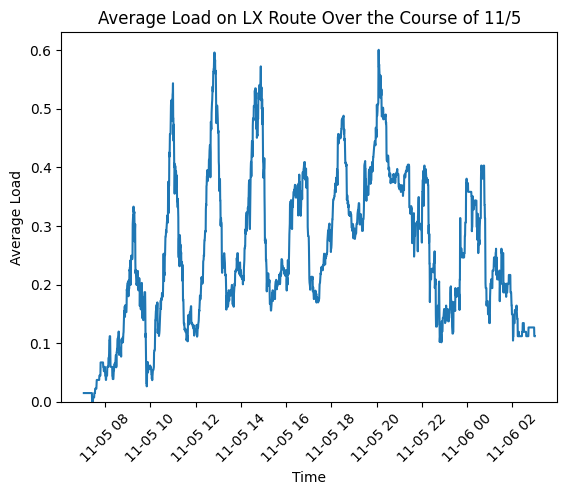

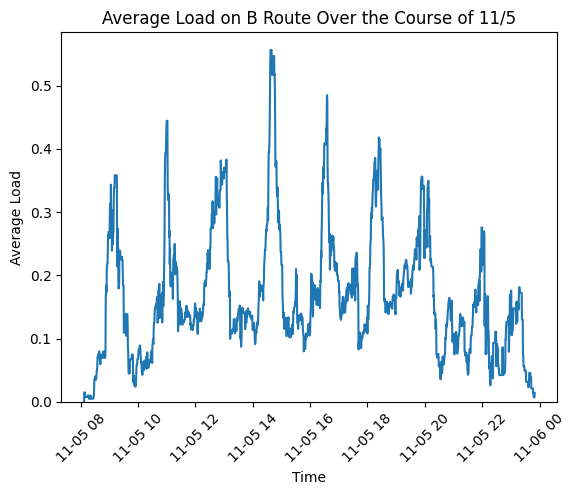

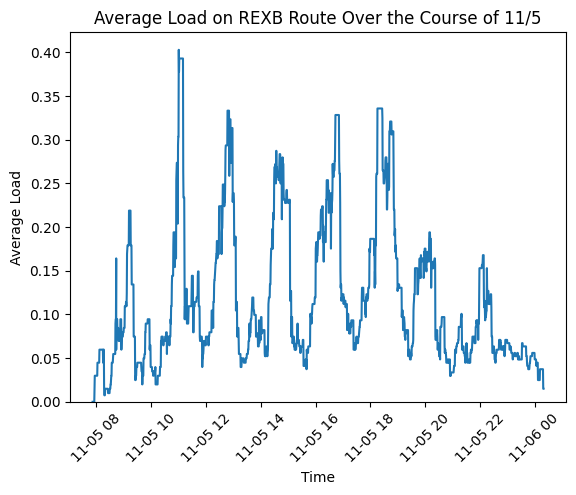

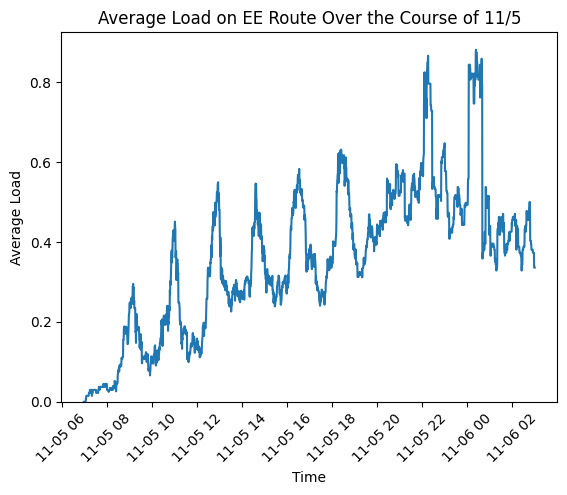

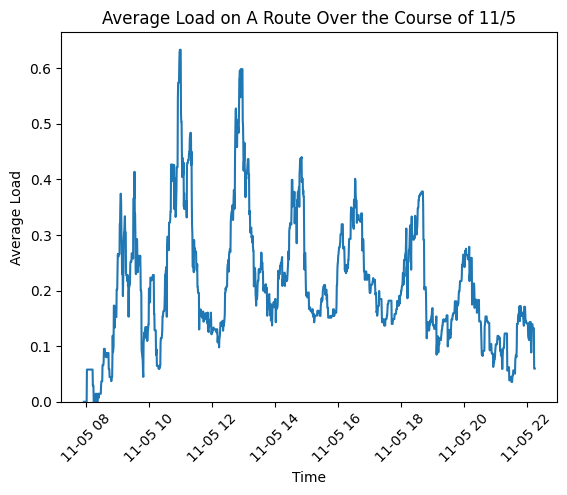

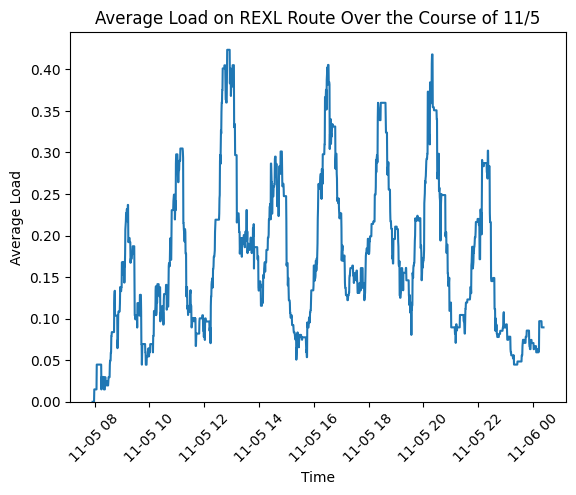

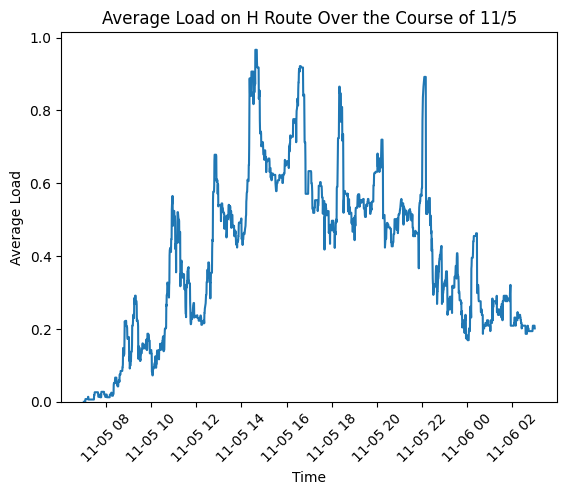

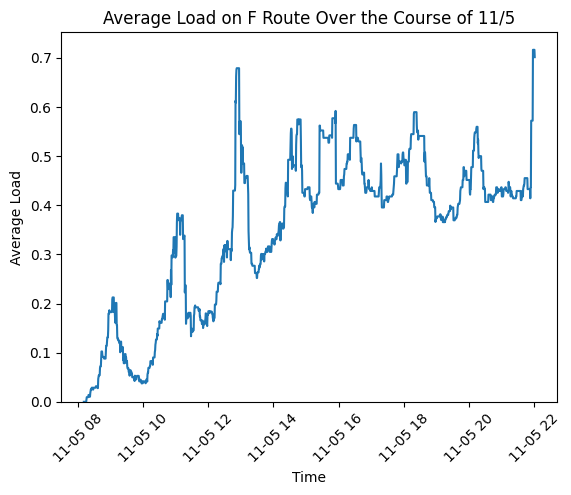

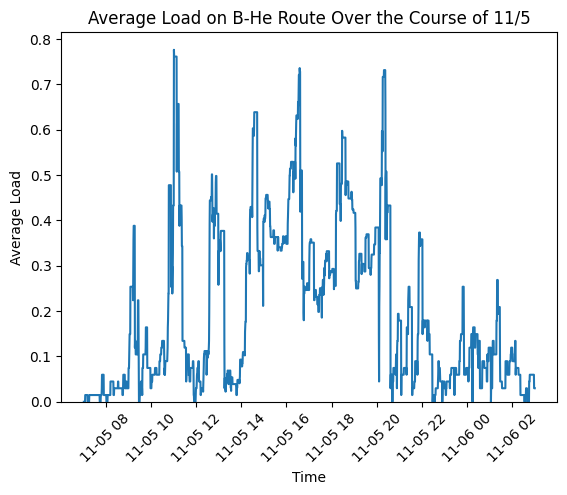

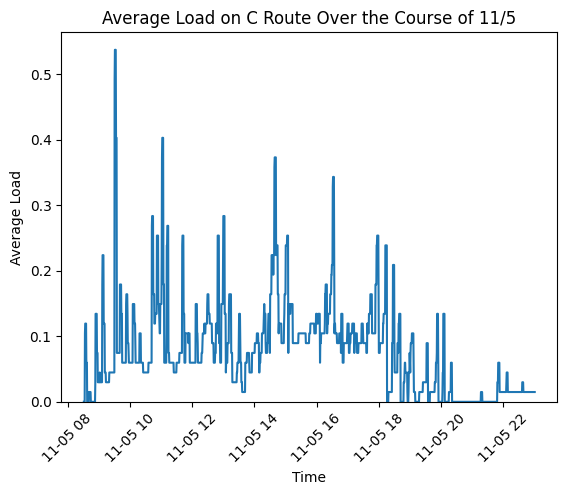

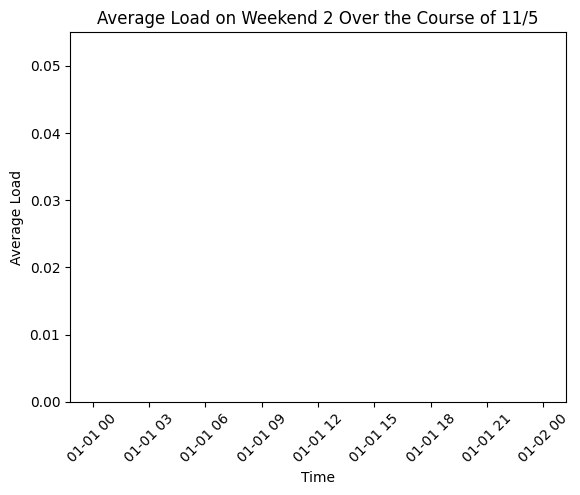

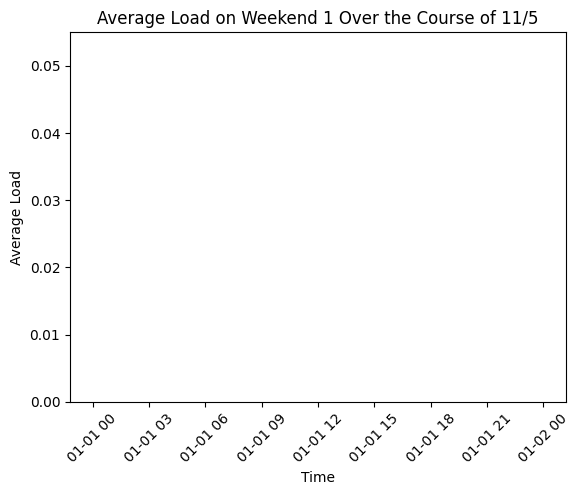

In [ ]:
# show average load on LX route over time
for route in data['routeName'].unique():
    # limit the data to one day
    data_time = data[(data['timestamp'] > '2024-11-05 6:00') & (data['timestamp'] < '2024-11-06 3:00')]

    # use timestamps from previous cell
    data_route = data_time[data_time['routeName'] == route]

    # get the average load at each timestamp
    timestamps = data_route['timestamp'].dt.floor('s').unique()
    load = []
    for timestamp in timestamps:
        load.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['load'].mean())

    plt.plot(timestamps, load)
    plt.xticks(rotation=45)
    plt.title(f'Average Load on {route} Over the Course of 11/5')
    plt.xlabel('Time')
    plt.ylabel('Average Load')
    plt.ylim(0)
    plt.show()

(0.0, 22.575)

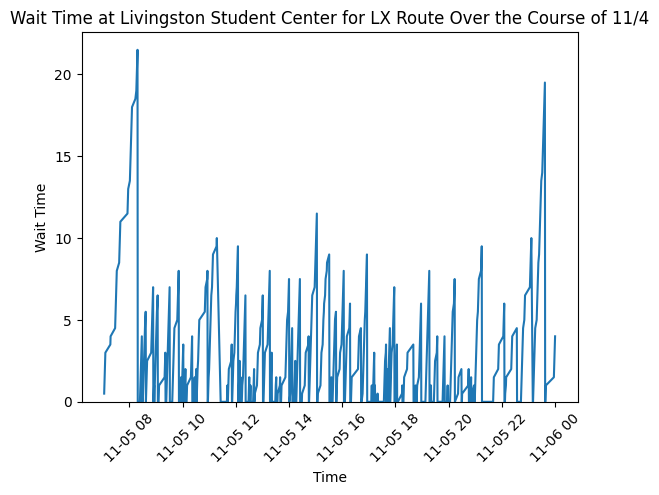

In [4]:
# for a given route and stop create a graph for the wait time to catch the next bus
route = 'LX Route'
stop = 'Livingston Student Center'
date_first = '11-05 6:00'
date_end = '11-06'

# limit the data to one day
data_time = data[(data['timestamp'] >= f'2024-{date_first}') & (data['timestamp'] < f'2024-{date_end}')]
data_route = data_time[data_time['routeName'] == route]
data_stop = data_route[data_route['stop'] == stop]

# get the wait time at each timestamp
timestamps = data_stop['timestamp'].dt.floor('s').unique()
wait = [0]
longest = []
for timestamp in timestamps:
    if len(data_stop[data_stop['timestamp'].dt.floor('s') == timestamp]) > 1:
        if wait[-1] != 0: longest.append(wait[-1])
        wait.append(0)
    else:
        wait.append(0.5 + wait[-1])

# remove the first element
wait = wait[1:]

plt.plot(timestamps, wait)
plt.xticks(rotation=45)
plt.title(f'Wait Time at {stop} for {route} Over the Course of 11/4')
plt.xlabel('Time')
plt.ylabel('Wait Time')
plt.ylim(0)


In [5]:
sum(wait) / len(wait)

2.5330188679245285

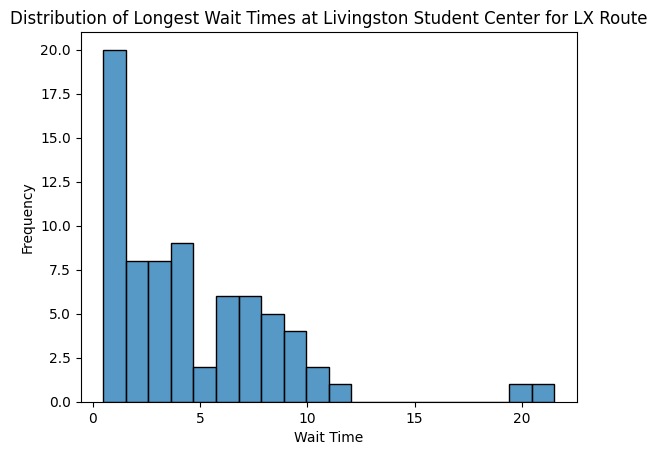

In [6]:
# graph the distribution of longest
sns.histplot(longest, bins=20)
plt.title(f'Distribution of Longest Wait Times at {stop} for {route}')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.show()